# Libraries

In [2]:
#the usual
import os
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for FFT
import scipy
#for Signal Processing
import pywt

# Useful Functions

### Dealing With CSV

In [3]:
# Clean CSV Output
# output of sensors is csv that may contain empty spaces 
# this function cleans the blank lines by rewriting all lines that are not empty
def remove_blank_lines(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    # Remove blank lines
    lines = [line for line in lines if line.strip()]
    
    with open(file_path, 'w', newline='') as file:
        file.writelines(lines)

In [4]:
# Force the data to be the same length
# when ending the recording the sensors may record different amount of data
# the final packets are not important so we drop them
def force_equal_data(mydf,minimum):
    for item in mydf:
        if len(mydf[item]) > minimum:
            mydf[item] = mydf[item][:minimum]

In [5]:
# Normalize Column
# take in a column of data and normalize it by subtracting its mean and dividing by its standard deviation
def normlize_column(column):
    mean = column.mean()
    std = column.std()
    for i in range (1,len(column)):
        column[i]= (column[i] - mean) / std
    return column

In [6]:
# Normalize Dataframe
# Normalize the columns of a dataframe
def normalize_df(df,columns_to_include = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']):
    newdf = pd.DataFrame()
    for item in df:
        if item in columns_to_include:
           newdf[item] = normlize_column(df[item])
        else:
            newdf[item] = df[item]
    return newdf

In [7]:
# Save dataframe into CSV
def save_df(df,name,savedir):
    print("Saving the File as: ", name + " processed.csv")
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    df.to_csv(savedir +  "\\" + name + "_processed" + ".csv", index=None, header=True)

### Data Viz

In [8]:
# Plot 3 parameters for 2 dataframes
def plot_axes_vertical(df1,df2,time,para1,para2,para3,name1='Data1',name2='Data2',start=0,end=1000,scale=1):
    start = start*60
    end = end*60
    fig, axs = plt.subplots(3, 1, figsize=( 10 *scale, 8*scale))
    plt.rcParams['axes.grid'] = True
    axs[0].plot(df1[time][start:end], df1[para1][start:end], label=name1, color='blue')
    axs[0].plot(df2[time][start:end], df2[para1][start:end], label=name2,color='red')
    axs[0].set_ylabel(para1)
    axs[1].plot(df1[time][start:end], df1[para2][start:end], label=name1, color='blue')
    axs[1].plot(df2[time][start:end], df2[para2][start:end], label=name2, color='red')
    axs[1].set_ylabel(para2)
    axs[2].plot(df1[time][start:end], df1[para3][start:end], label=name1, color='blue')
    axs[2].plot(df2[time][start:end], df2[para3][start:end], label=name2, color='red')
    axs[2].set_ylabel(para3)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center')

In [9]:
# Plot 1 parameter for 2 dataframes
# can specify the start and end of the plot
def compare_plot_inrange(df1,df2,time,para1,para2,scale=1,start=0,end=500,name1='Data1',name2='Data2'):
    start = start*60
    end = end*60
    plt.figure(figsize=(10*scale, 5*scale)) 
    plt.plot(df1[time][start:end], df1[para1][start:end], label=name1, color='blue')
    plt.plot(df2[time][start:end], df2[para2][start:end], label=name2, color='red')
    plt.xlabel(time)
    if para1 == para2:
        plt.ylabel(para1)
    else:
        plt.ylabel(para1 + ' and ' + para2)
    plt.legend()

In [13]:
#Plot Quaternions for 1 dataframe
def plot_quat_inrange(df1,point_in_time=-1,time='Time',scale=1,start=0,end=500):
    para1='Quat_W'
    para2='Quat_X'
    para3='Quat_Y'
    para4='Quat_Z'
    start = start*60
    end = end*60

    if point_in_time > 0:
        # Get the values at the specified point in time
        quat_w = df1['Quat_W'][point_in_time]
        quat_x = df1['Quat_X'][point_in_time]
        quat_y = df1['Quat_Y'][point_in_time]
        quat_z = df1['Quat_Z'][point_in_time]
        # Print the values
        print(f"Quat_W: {quat_w}")
        print(f"Quat_X: {quat_x}")
        print(f"Quat_Y: {quat_y}")
        print(f"Quat_Z: {quat_z}")

    plt.figure(figsize=(10*scale, 5*scale))
    plt.plot(df1[time][start:end], df1[para1][start:end], label=para1, color='blue')
    plt.plot(df1[time][start:end], df1[para2][start:end], label=para2, color='red')
    plt.plot(df1[time][start:end], df1[para3][start:end], label=para3, color='green')
    plt.plot(df1[time][start:end], df1[para4][start:end], label=para4, color='orange')
    plt.xlabel(time)
    plt.xticks(np.arange(start/60, end/60,step=round(60/scale)))
    
    plt.legend()

### Signal Processing

In [14]:
# Denosing Wavelet Transform
# takes the whole dataframe and denoises specific columns
# the last 3 levels of the wavelet transform are set to zero to remove noise
def denoise_dataframe(df,columns_to_include = ['Acc_X', 'Acc_Y', 'Acc_Z','Gyr_X', 'Gyr_Y', 'Gyr_Z']):
    wavelet = 'db4'
    for column in df.columns:
        if column in columns_to_include:
            FPData = np.array(df[column]).astype('float32')
            DWTcoeffs = pywt.wavedec(FPData[:], wavelet)
            DWTcoeffs[-1] = np.zeros_like(DWTcoeffs[-1])
            DWTcoeffs[-2] = np.zeros_like(DWTcoeffs[-2]) 
            DWTcoeffs[-3] = np.zeros_like(DWTcoeffs[-3])
            DWTcoeffs[-4] = np.zeros_like(DWTcoeffs[-4])
            #DWTcoeffs[-5] = np.zeros_like(DWTcoeffs[-5])
            FPData_Decompos=pywt.waverec(DWTcoeffs,wavelet,mode='symmetric',axis=-1)
            if (len(FPData_Decompos) != len(FPData)):
                FPData_Decompos = FPData_Decompos[0:len(FPData)]
            df[column] = FPData_Decompos
            df[column][0] = 0
    return df

In [15]:
#Moving Average Filter Column
def moving_average_column (column, window):
    return column.rolling(window=window,min_periods=1).mean()

In [16]:
# Moving average Filter DataFrame 
# over a window = 60 samples (1 second) to reduce fluctuations due to signal distortions
def moving_average_df(df,window_size=60,columns_to_include = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z'] ):
    newdf = pd.DataFrame()
    for item in df.columns:
        if item in columns_to_include:
            newdf[item] = moving_average_column(df[item],window_size)
        else:
            newdf[item] = df[item]
    return newdf

In [17]:
#FFT
# Given a dataframe column, N being Sample Rate, F being Frequency of the signal, 
# threshold being the threshold to ignore freq. below it for the FFT, and the plot_range to plot the FFT
def plot_fft(df,pc,N=1000,F=800,threshold=200,plot_range=1000,scale=1,reconstruct=False):
    # sample spacing
    T = 1.0 / F
    yf = scipy.fftpack.fft(df.values)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    for i, value in enumerate(yf):
        if np.abs(value) < threshold:
            yf[i] = 0
    reconstructed = scipy.fftpack.ifft(yf)
    if reconstruct:
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10* 2 *scale , 10* scale))
        ax1.plot(xf[:plot_range], 2.0/N * np.abs(yf[:N//2])[:plot_range])
        ax2.plot(pc[:], reconstructed[:])
    else:
        fig,ax = plt.subplots(1,1,figsize=(10* 2 *scale , 10* scale))
        ax.plot(xf[:plot_range], 2.0/N * np.abs(yf[:N//2])[:plot_range])
    plt.show()
    return yf

In [18]:
#Velocity Calculation Column
def Compute_Velo(dfprime,paratobeadded,para2,sampling_rate=60):
    if paratobeadded not in dfprime.columns:
        dfprime.insert( len(dfprime.columns), paratobeadded,0)
        #dfprime[0,paratobeadded] = 0
        for i in range(1,len(dfprime[para2])):
            # Vn = Vn-1 + An * (1/sampling_rate) assuming V0 = 0 and A0 = 0
            AvgAcc = (dfprime[para2][i]+dfprime[para2][i-1])/2
            if abs(AvgAcc) < 0.01 :
                result = 0
            else:
                result = dfprime[paratobeadded][i-1] + dfprime[para2][i] * (1/sampling_rate) 
            (dfprime.loc[i,paratobeadded]) = round(  result ,6 )

In [19]:
#Velocity Calculation DataFrame
mydict = {'Velo_X':'Acc_X','Velo_Y':'Acc_Y','Velo_Z':'Acc_Z'}
velolist = ['Velo_X','Velo_Y','Velo_Z']
def Compute_All_Velo(df):
    newdf = pd.DataFrame()
    newdf = df
    for item in velolist:
        if item not in newdf.columns:
            Compute_Velo(newdf,item,mydict[item],sampling_rate=60)
    return newdf

In [20]:
#Compute Time in Sec
def Compute_Time_inSec(df):
    if 'Time' not in df.columns:
        df.insert( len(df.columns), 'Time',0)
        for i in range(1,len(df['PacketCounter'])):
            result = df['PacketCounter'][i] * (1/60)
            (df.loc[i,'Time']) = round(  result ,6 )
    return df

In [21]:
# Convert Angle data 360
# by default the angle data is in the range of -180 to 180, this function converts it to 0 to 360 range, 
# this is done by preserving the positive values, and adding 360 to the negative values
def convert_angle_df(df):
    compute = ['Euler_X', 'Euler_Y', 'Euler_Z']
    for column in compute:
        for i, value in enumerate(df[column]):
            if value < 0:
                df[column][i] = df[column][i] + 360
    return df

In [22]:
# Fix Angles
# the angle data ranges from 0 to 360 degrees when converted
# this functions corrects data from the sensor
# any angle that is between [0,90] or [270,360] is converted to 180 neck rotation constraint (+ far peripheral)
def fix_angles(column, far_peripheral_apprx=20,near_peripheral_apprx=10):
    for i in range(1,len(column)):
        if column[i] >=270 +far_peripheral_apprx or column[i] <=90 + far_peripheral_apprx: 
            column[i] = column[i-1]
        #if value >= 180 - near_peripheral_apprx and value <= 180 + near_peripheral_apprx:
        #    column[i] = 180
        #if abs(column[i] - column[i-1]) >= 50 and i > 1:
        #    column[i] = column[i-1]
    return column

In [94]:
#Pearson Correlation Coefficient of Moving Averages
def pc_compare_same(df,df2,item,visual = False):
    cor_coeff = scipy.stats.pearsonr(df[item],df2[item])
    if visual:
        print('The Pearson Correlation Coefficient for ' + item + ' is: ', cor_coeff)
        compare_plot_inrange(df,df2,'Time',item,item,start=0,end=500,name1='Person One',name2='Person Two',scale=0.5)
    return cor_coeff

In [95]:
#Pearson Correlation Coefficient of Moving Averages
def pc_compare_diff(df,df2,item1,item2,visual = False):
    cor_coeff = scipy.stats.pearsonr(df[item1],df2[item2])
    if visual:
        print('The Pearson Correlation Coefficient for ' + item1 + 'vs ' + item2 + ' is: ', cor_coeff)
        compare_plot_inrange(df,df2,'Time',item1,item2,start=0,end=500,name1='Person One',name2='Person Two',scale=0.5)
    return cor_coeff

In [111]:
# Plot Pearson Correlation Matrix
# Given 4 dataframes, this function calculates the Pearson Correlation Coefficient between all of them
# for a given parameter, and plots the correlation matrix
def plot_pearson_dataframes_mat(df4,df5,sdf4,sdf5,para='Acc_X',names=['D1','D2','D3','D4']):
    # Create a list of the correlation coefficients
    correlation_values = [                1                  ,pc_compare_same(df4,df5,para)[0] ,pc_compare_same(df4,sdf4,para)[0] ,pc_compare_same(df4,sdf5,para)[0] ,
                           pc_compare_same(df5,df4,para)[0]  ,           1                     ,pc_compare_same(df5,sdf4,para)[0] ,pc_compare_same(df5,sdf5,para)[0] ,
                           pc_compare_same(sdf4,df4,para)[0] ,pc_compare_same(sdf4,df5,para)[0],            1                     ,pc_compare_same(sdf4,sdf5,para)[0],
                           pc_compare_same(df4,sdf5,para)[0] ,pc_compare_same(df5,sdf5,para)[0],pc_compare_same(sdf4,sdf5,para)[0],              1                   ]

    # Create a list of the dataframe names
    dataframe_names = [names[0], names[1], names[2], names[3]]

    # Create a correlation matrix
    correlation_matrix = [ correlation_values[0:4], correlation_values[4:8], correlation_values[8:12], correlation_values[12:16] ]

    # Create a heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=dataframe_names, yticklabels=dataframe_names)

    # Set the title and labels
    plt.title('Pearson Correlation Coefficients')

    # Show the plot
    plt.show()

In [107]:
# Plot Pearson Correlation Matrix
# Given 4 dataframes, this function calculates the Pearson Correlation Coefficient between all of them
# for a given parameter, and plots the correlation matrix
def plot_pearson_quant_mat(d1,d2):
    para1 = 'Quat_W'
    para2 = 'Quat_X'
    para3 = 'Quat_Y'
    para4 = 'Quat_Z'
    # Create a list of the correlation coefficients
    correlation_values = [ pc_compare_diff(d1,d2,para1,para1)[0], pc_compare_diff(d1,d2,para1,para2)[0], pc_compare_diff(d1,d2,para1,para3)[0],pc_compare_diff(d1,d2,para1,para4)[0],
                           pc_compare_diff(d1,d2,para2,para1)[0], pc_compare_diff(d1,d2,para2,para2)[0], pc_compare_diff(d1,d2,para2,para3)[0],pc_compare_diff(d1,d2,para2,para4)[0],
                           pc_compare_diff(d1,d2,para3,para1)[0], pc_compare_diff(d1,d2,para3,para2)[0], pc_compare_diff(d1,d2,para3,para3)[0],pc_compare_diff(d1,d2,para3,para4)[0],
                           pc_compare_diff(d1,d2,para4,para1)[0], pc_compare_diff(d1,d2,para4,para2)[0], pc_compare_diff(d1,d2,para4,para3)[0],pc_compare_diff(d1,d2,para4,para4)[0]  ]

    # Create a list of the dataframe names
    parameter_names = [para1, para2, para3, para4]
    parameter_names2 = [item + '2' for item in parameter_names] 
    # Create a correlation matrix
    correlation_matrix = [ correlation_values[0:4], correlation_values[4:8], correlation_values[8:12], correlation_values[12:16] ]

    correlation_matrix = pd.DataFrame(correlation_matrix, columns=parameter_names, index=parameter_names2)
    # Create a heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=parameter_names, yticklabels=parameter_names2)

    # Set the title and labels
    plt.title('Pearson Correlation Coefficients')

    # Show the plot
    plt.show()

## COMBINE EVERYTHING FUNCTION

In [25]:
# Read and Process
def read_all_csv_files_with_processing(mydirectory,savedir,save=False,denoise = False,comp_velo=False,normalize=False):
    minimum = -1
    mydf = {}
    for filename in os.listdir(mydirectory):
        if filename.endswith('.csv'):
            myname = filename.split('_')[0:1]
            file_path = os.path.join(mydirectory, filename)
            print("Reading File: " + filename)
            remove_blank_lines(file_path)
            df = pd.read_table(file_path,sep=',',skip_blank_lines=True,na_filter=True)
            df = df.dropna()
            df = Compute_Time_inSec(df)
            #df = convert_angle_df(df)
            if len(df) < minimum or minimum == -1:
                minimum = len(df)
            if "Unnamed: 11" in df.columns:
                df.drop("Unnamed: 11", axis=1, inplace=True)
            if "Unnamed: 12" in df.columns:
                df.drop("Unnamed: 12", axis=1, inplace=True)
            if denoise:
                print('Denoising...')
                df = denoise_dataframe(df)
            if normalize:
                print('Normalizing...')
                df = normalize_df(df)
            if comp_velo:
                print("Will Start Computing Velocities for " + myname[0])
                df = Compute_All_Velo(df)
            mydf[ myname[0] ] = df
    print("The minimum number of rows is: " + str(minimum) + " rows")
    force_equal_data(mydf,minimum)
    if save:
        for item in mydf:
            save_df(mydf[item],item,savedir)
    print (mydf.keys())
    return mydf

In [26]:
# Read Only
def read_ready_files(mydirectory):
    minimum = -1
    mydf = {}
    for filename in os.listdir(mydirectory):
        if filename.endswith('.csv'):
            myname = filename.split('_')[0:1]
            file_path = os.path.join(mydirectory, filename)
            print("Reading File: " + filename)
            df = pd.read_table(file_path,sep=',',skip_blank_lines=True,na_filter=True)
            mydf[ myname[0] ] = df
    print (mydf.keys())
    return mydf

In [27]:
# Process Moving Average Filter for Limbs
# I didn't include this in the may read and process function because it is not always needed
def moving_average_of_limbs(mydf):
    list = ['Right Hand','Left Hand','Right Foot','Left Foot','Right Hand2','Left Hand2','Right Foot2','Left Foot2']
    for item in list:
        mydf[item] = moving_average_df(mydf[item],window_size=60)
    return mydf

# Analysis

## Directory

In [36]:
mydirectory = r'.\data\YJP\Quaternions'
savedir = os.path.join(mydirectory,'Processed')
readdir= r'.\data\YJP\Quaternions\Processed'

In [37]:
mydf = read_all_csv_files_with_processing(mydirectory,savedir,denoise=False,save=True,comp_velo=False,normalize=True)

Reading File: Headnew_D422CD008B5C_20240318_112551.csv
Normalizing...
The minimum number of rows is: 30102 rows
Saving the File as:  Headnew processed.csv
dict_keys(['Headnew'])


In [78]:
mydf = read_ready_files(readdir)

Reading File: Head2_processed.csv
Reading File: Head_processed.csv
Reading File: Left Foot2_processed.csv
Reading File: Left Foot_processed.csv
Reading File: Left Hand2_processed.csv
Reading File: Left Hand_processed.csv
Reading File: Right Foot2_processed.csv
Reading File: Right Foot_processed.csv
Reading File: Right Hand2_processed.csv
Reading File: Right Hand_processed.csv
dict_keys(['Head2', 'Head', 'Left Foot2', 'Left Foot', 'Left Hand2', 'Left Hand', 'Right Foot2', 'Right Foot', 'Right Hand2', 'Right Hand'])


In [79]:
mydf = moving_average_of_limbs(mydf)

In [80]:
df = mydf['Head']
df2 = mydf['Right Hand']
df3 = mydf['Left Hand']
df4 = mydf['Right Foot']    
df5 = mydf['Left Foot']

sdf = mydf['Head2']
sdf2 = mydf['Right Hand2']
sdf3 = mydf['Left Hand2']
sdf4 = mydf['Right Foot2']    
sdf5 = mydf['Left Foot2']

## Plots

### HANDS

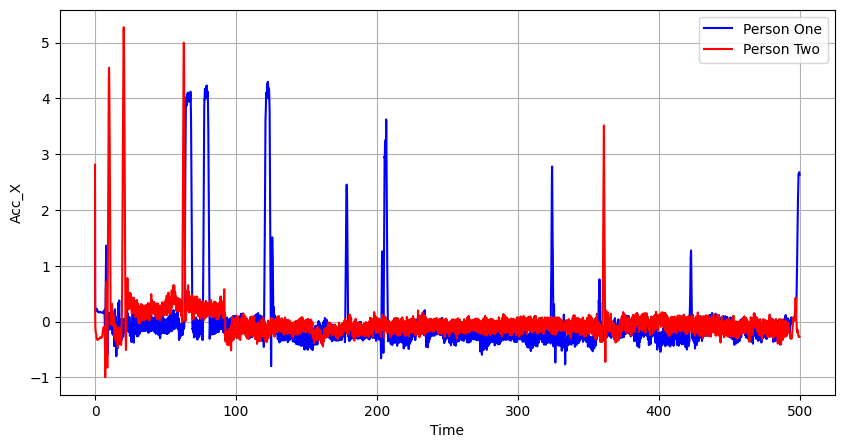

In [54]:
compare_plot_inrange(df2,sdf2,'Time','Acc_X','Acc_X',start=0,end=500,name1='Person One',name2='Person Two',scale=1)

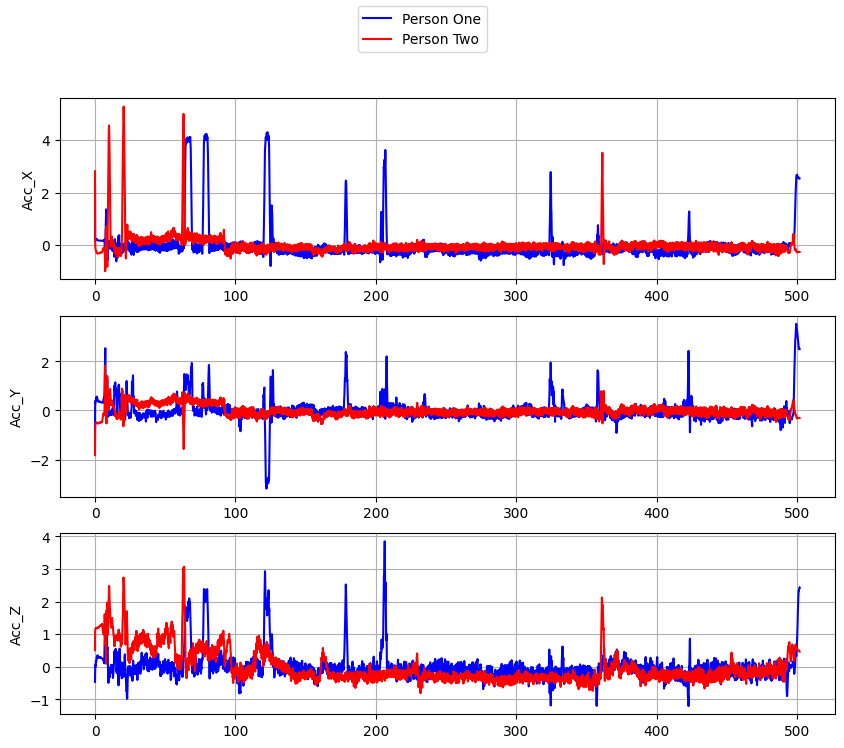

In [55]:
plot_axes_vertical(df2,sdf2,'Time','Acc_X','Acc_Y','Acc_Z',name1='Person One',name2='Person Two',start=000,end=30000)

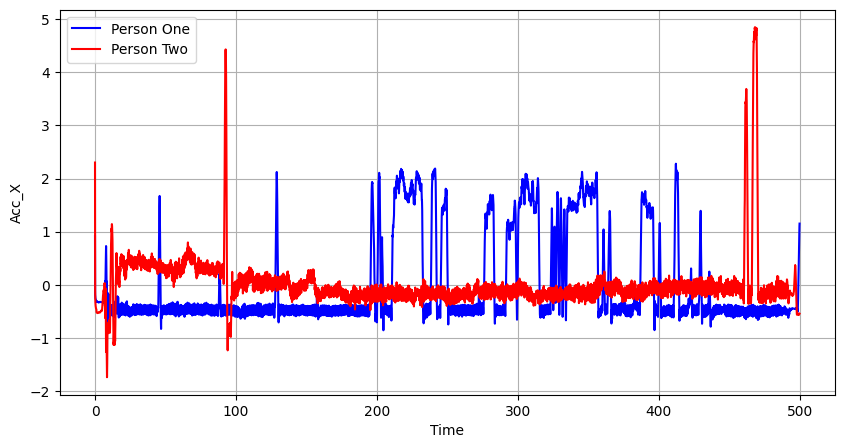

In [56]:
compare_plot_inrange(df3,sdf3,'Time','Acc_X','Acc_X',start=0,end=500,name1='Person One',name2='Person Two',scale=1)

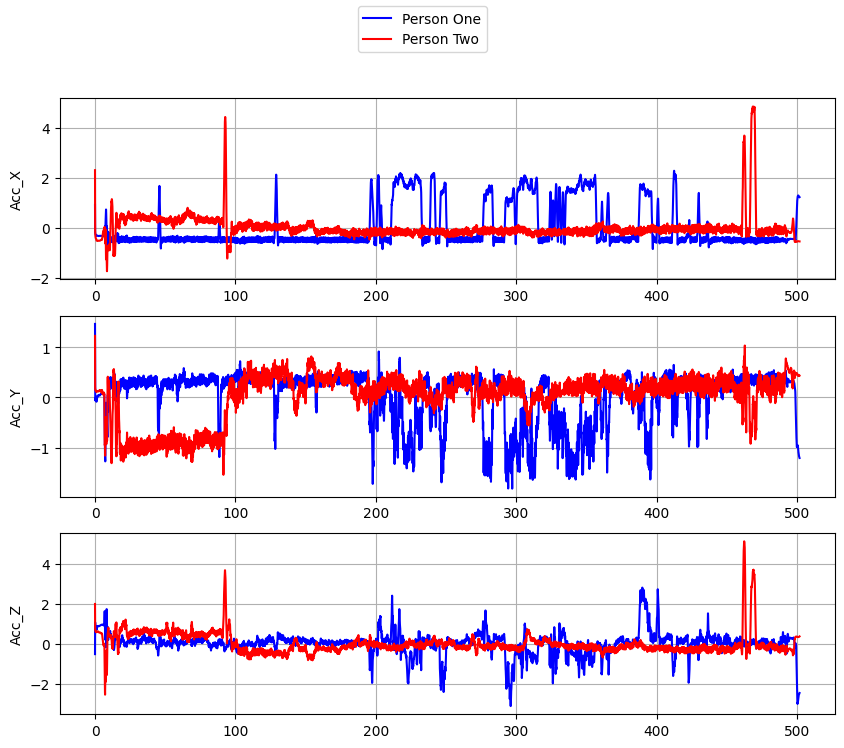

In [57]:
plot_axes_vertical(df3,sdf3,'Time','Acc_X','Acc_Y','Acc_Z',name1='Person One',name2='Person Two',start=000,end=30000)

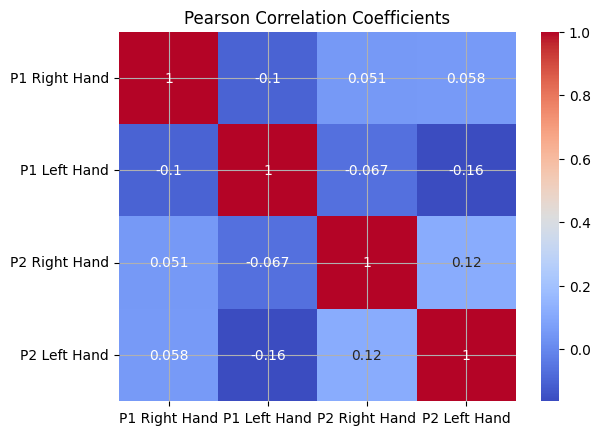

In [112]:
plot_pearson_dataframes_mat(df2,df3,sdf2,sdf3,para='Acc_X',names=['P1 Right Hand','P1 Left Hand','P2 Right Hand','P2 Left Hand'])

### LEGS

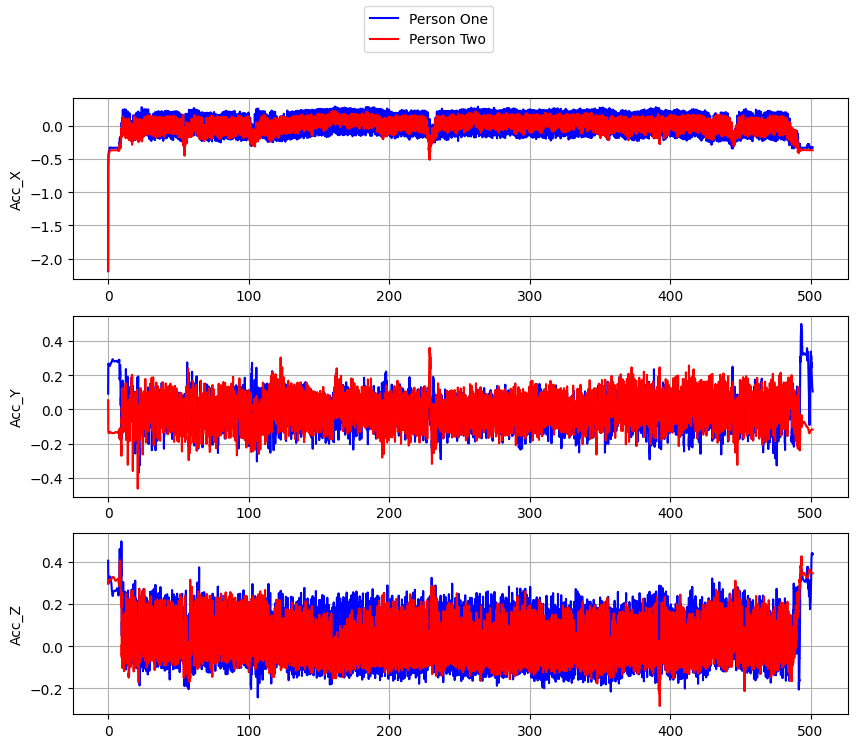

In [59]:
plot_axes_vertical(df4,sdf4,'Time','Acc_X','Acc_Y','Acc_Z',name1='Person One',name2='Person Two',start=000,end=30000)

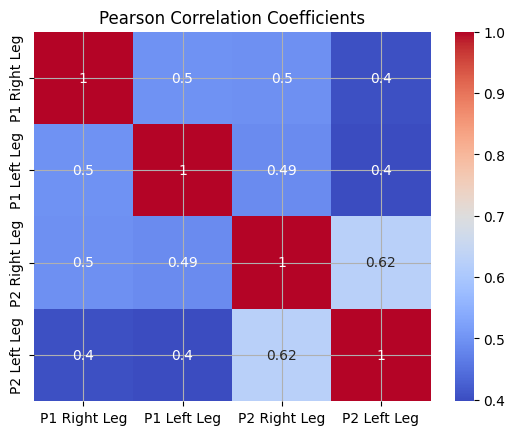

In [60]:
plot_pearson_dataframes_mat(df4,df5,sdf4,sdf5,para='Acc_X',names=['P1 Right Leg','P1 Left Leg','P2 Right Leg','P2 Left Leg'])

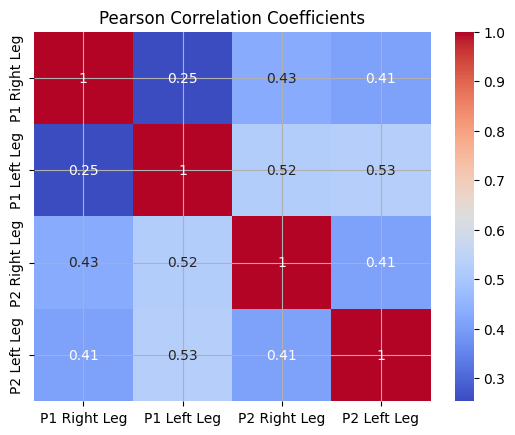

In [61]:
plot_pearson_dataframes_mat(df4,df5,sdf4,sdf5,para='Acc_Z',names=['P1 Right Leg','P1 Left Leg','P2 Right Leg','P2 Left Leg'])

### HEADS

In [81]:
df = moving_average_df(df,window_size=600,columns_to_include = ['Quat_W','Quat_X','Quat_Y','Quat_Z'] )

In [82]:
sdf = moving_average_df(sdf,window_size=600,columns_to_include = ['Quat_W','Quat_X','Quat_Y','Quat_Z'] )

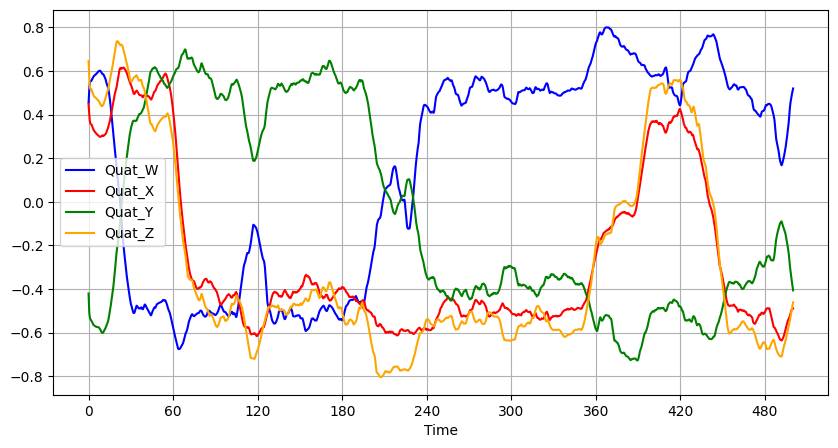

In [83]:
plot_quat_inrange(df,scale=1)

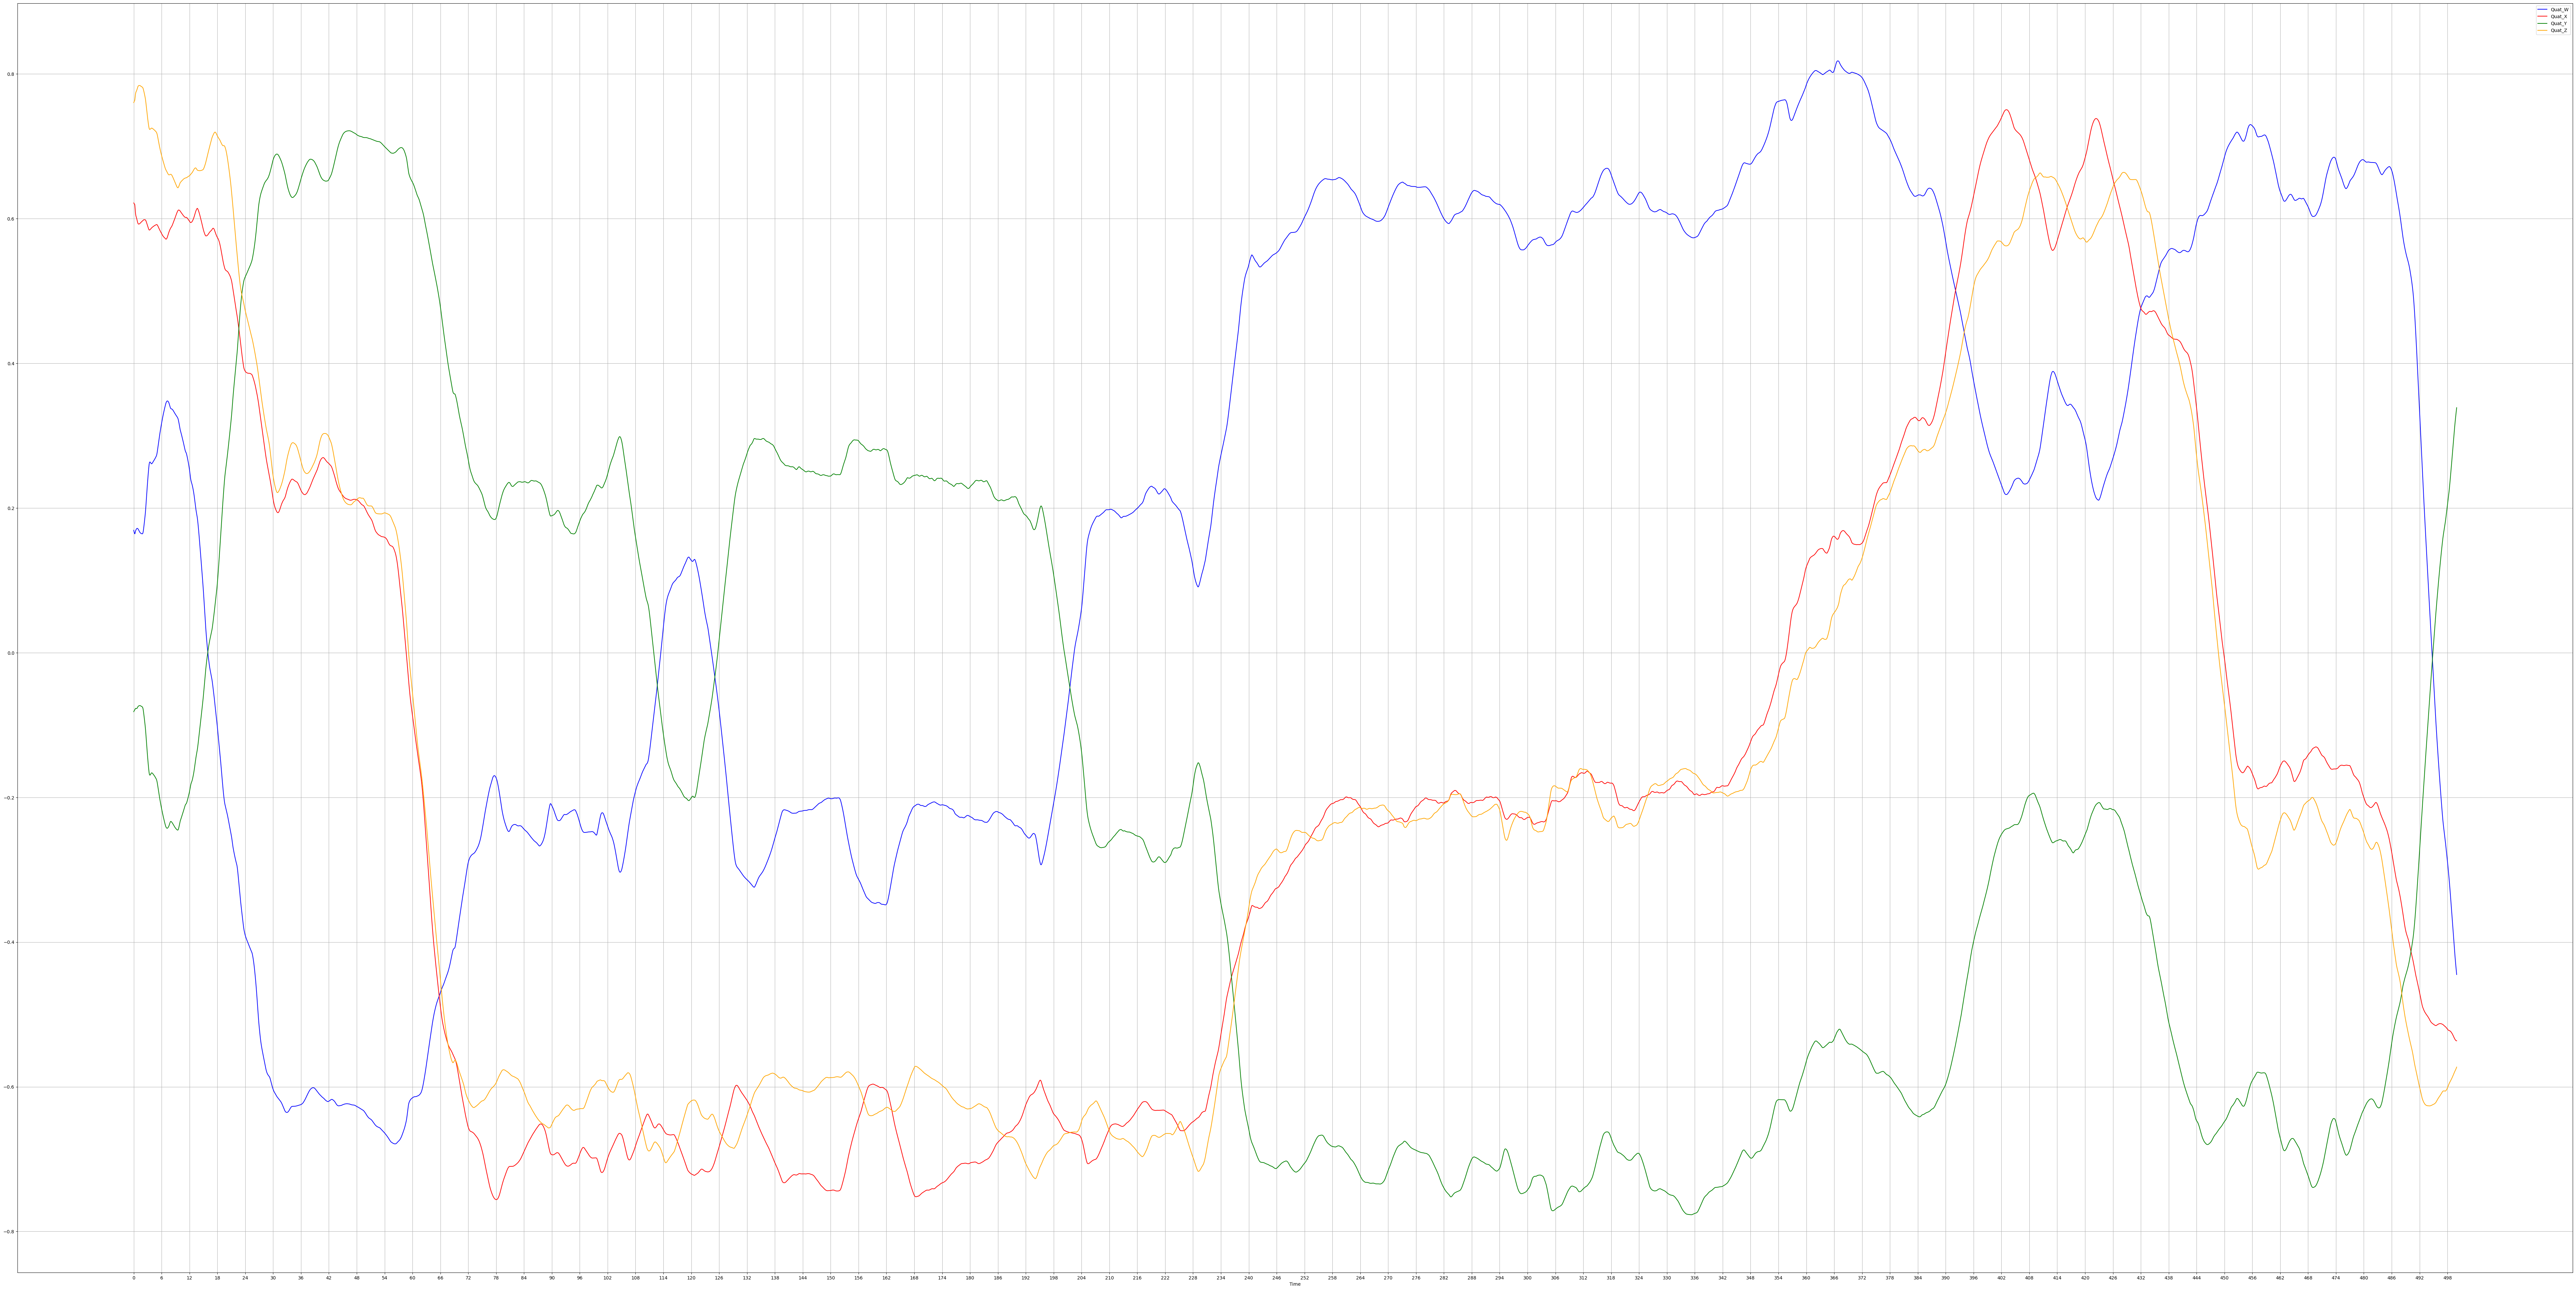

In [109]:
plot_quat_inrange(sdf,scale=10)

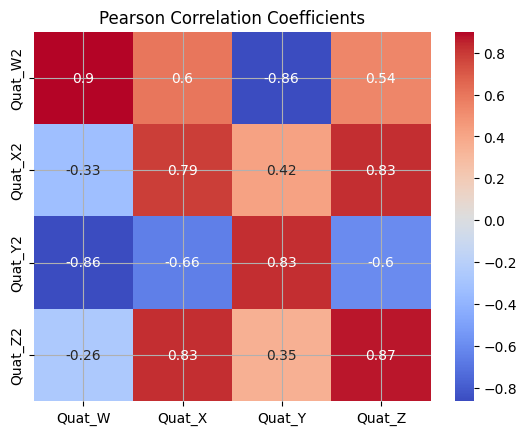

In [108]:
plot_pearson_quant_mat(df,sdf)